## M3 - SB-LSTM-RNN with Hyperparameter GridSearch

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#!pip install scikit-learn==1.2.2
#!pip install tensoflow==2.14.0
#!pip install keras==2.14.0
!pip install scikeras==0.12.0
!pip install joblib==1.2.0
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.0
    Uninstalling joblib-1.4.0:
      Successfully uninstalled joblib-1.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 23.6 MB/s eta 0:00:00


In [3]:
# pustaka manipulasi data array
import numpy as np

# pustaka manipulasi data frame
import pandas as pd
from pandas import concat
from pandas import DataFrame
from pandas import read_csv
from pandas import read_excel

import random as rm
import time as tm

# pustaka untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# library normalize data with max-min algorithm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# library algorithm lstm-rnn with keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import RNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.optimizers import Adam, Adamax, RMSprop, SGD
from keras.layers import LeakyReLU

# pustaka untuk visualisasi acf dan pacf
import scipy.stats as sc
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

# pustaka untuk  evaluasi model prediksi
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

### Config Models

In [4]:
# Setting seed
rm.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [5]:
# Setting Algorithm
algorithm = "LSTM-RNN"

In [6]:
# # Setting Algorithm
# algorithm = "GRU-RNN"

### 1. Akuisisi Data

In [7]:
# Set waktu komputasi
start = tm.time()

In [8]:
dataset = pd.read_csv("/content/drive/MyDrive/BOPTN_2024/dataset_enso.csv", parse_dates=["acq_date"])
#dataset = pd.read_csv("../source-code/dataset/dataset_enso.csv", parse_dates=["acq_date"])

In [9]:
# menampilkan metadata dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   acq_date  276 non-null    datetime64[ns]
 1   hotspot   276 non-null    int64         
 2   sst_std   276 non-null    float64       
 3   sst_anom  276 non-null    float64       
 4   oni_std   276 non-null    float64       
 5   oni_anom  276 non-null    float64       
 6   soi_std   276 non-null    float64       
 7   soi_anom  276 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 17.4 KB


In [10]:
print(dataset.head())

    acq_date  hotspot  sst_std  sst_anom  oni_std  oni_anom  soi_std  soi_anom
0 2001-01-31        3    25.81     -0.76    25.88     -0.68      1.0       1.6
1 2001-02-28        5    26.18     -0.56    26.26     -0.52      1.7       2.8
2 2001-03-31       10    26.86     -0.37    26.76     -0.44      0.9       1.5
3 2001-04-30       20    27.24     -0.56    27.25     -0.34      0.2       0.3
4 2001-05-31       39    27.42     -0.46    27.49     -0.25     -0.5      -0.8


### 2. Praproses Data

- Seleksi Fitur

In [11]:
# jika hotspot dipengaruhi oleh enso
data = dataset[["hotspot", "sst_std", "sst_anom", "oni_std", "oni_anom", "soi_std", "soi_anom"]]
data = data.values

# # jika hotspot dipengaruhi oleh enso
# data = dataset[["hotspot", "sst_anom", "oni_anom", "soi_anom"]]
# data = data.values

In [12]:
# hasil seleksi fitur
np.round(data[:5],7)

array([[ 3.  , 25.81, -0.76, 25.88, -0.68,  1.  ,  1.6 ],
       [ 5.  , 26.18, -0.56, 26.26, -0.52,  1.7 ,  2.8 ],
       [10.  , 26.86, -0.37, 26.76, -0.44,  0.9 ,  1.5 ],
       [20.  , 27.24, -0.56, 27.25, -0.34,  0.2 ,  0.3 ],
       [39.  , 27.42, -0.46, 27.49, -0.25, -0.5 , -0.8 ]])

In [13]:
# cek dimensi normalisasi
data.shape

(276, 7)

- Normalisasi Data

In [14]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(np.array(data))

In [15]:
# show data train
np.round(scaled[:5],4)

array([[-1.    , -0.6324, -0.6148, -0.5869, -0.5514,  0.3667,  0.36  ],
       [-0.9997, -0.4705, -0.522 , -0.4085, -0.4766,  0.6   ,  0.6   ],
       [-0.999 , -0.1729, -0.4339, -0.1737, -0.4393,  0.3333,  0.34  ],
       [-0.9976, -0.0066, -0.522 ,  0.0563, -0.3925,  0.1   ,  0.1   ],
       [-0.995 ,  0.0722, -0.4756,  0.169 , -0.3505, -0.1333, -0.12  ]])

In [16]:
# cek dimensi normalisasi
scaled.shape

(276, 7)

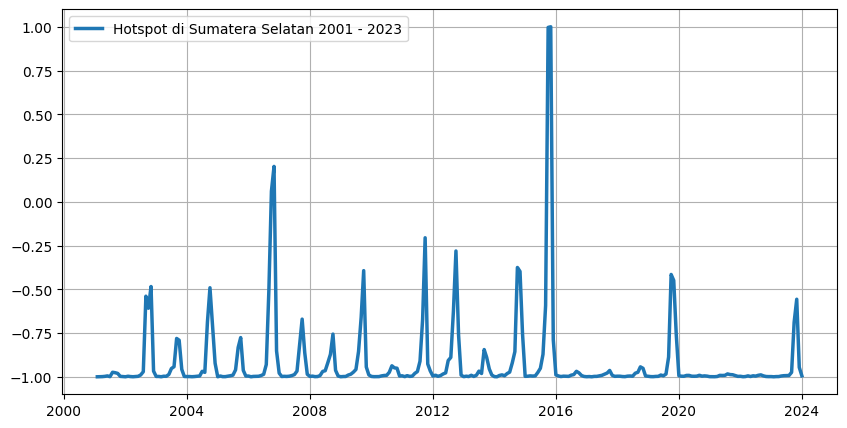

In [17]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset["acq_date"], np.array(scaled[:,:1]), color="tab:blue", label="Hotspot di Sumatera Selatan 2001 - 2023", linewidth=2.5)

# membuat label-label
ax.set_title("", fontsize=14)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="upper left")
ax.grid(True)

# menampilkan plot
plt.show()

### 3. Pembagian Data

In [18]:
# data train
train_size = 216

# set loc data train
train_data = scaled[0:train_size,:]

# show data train
np.round(train_data[:5],4)

array([[-1.    , -0.6324, -0.6148, -0.5869, -0.5514,  0.3667,  0.36  ],
       [-0.9997, -0.4705, -0.522 , -0.4085, -0.4766,  0.6   ,  0.6   ],
       [-0.999 , -0.1729, -0.4339, -0.1737, -0.4393,  0.3333,  0.34  ],
       [-0.9976, -0.0066, -0.522 ,  0.0563, -0.3925,  0.1   ,  0.1   ],
       [-0.995 ,  0.0722, -0.4756,  0.169 , -0.3505, -0.1333, -0.12  ]])

In [19]:
train_data.shape

(216, 7)

In [20]:
# data test
test_size = 60

# set loc data test
test_data = scaled[train_size:len(scaled),:]

# show data test
np.round(test_data[:5],4)

array([[-0.999 , -0.0066,  0.0487,  0.1221,  0.1168,  0.0333,  0.02  ],
       [-0.9993,  0.081 ,  0.0673,  0.216 ,  0.1028, -0.4333, -0.42  ],
       [-0.9979,  0.4179,  0.1879,  0.4131,  0.0981, -0.0667, -0.06  ],
       [-0.9975,  0.558 ,  0.0719,  0.5681,  0.0748,  0.0667,  0.08  ],
       [-0.99  ,  0.6018,  0.0858,  0.5822,  0.0187, -0.1   , -0.1   ]])

In [21]:
test_data.shape

(60, 7)

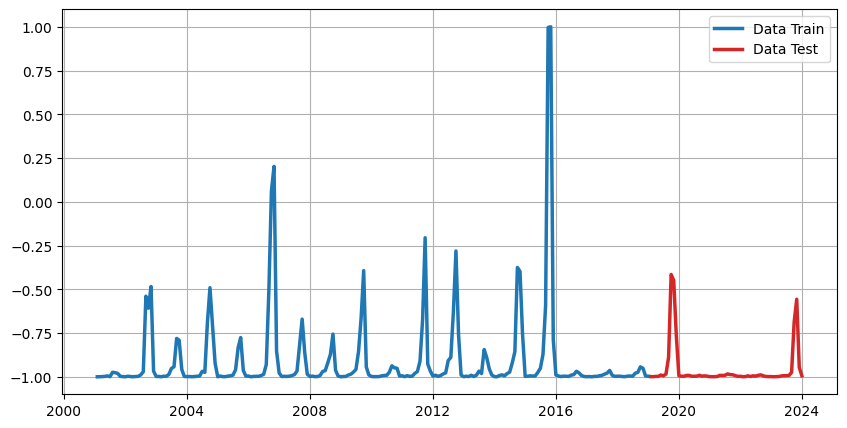

In [22]:
# make a frame
fig, ax = plt.subplots(figsize = (10,5))

# make a time series plot
ax.plot(dataset.iloc[0:len(train_data),0], train_data[:,:1], color="tab:blue", label="Data Train", linewidth=2.5)
ax.plot(dataset.iloc[len(train_data):len(dataset),0], test_data[:,:1], color="tab:red", label="Data Test", linewidth=2.5)

# make are labels
ax.set_title("", fontsize=14)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="best")
ax.grid(True)

# show plot time series
plt.show()

### 4. Supervised Learning

In [23]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    # return value
    return agg

- hasil supervised learning data train

In [24]:
# set supervised learning for data train
reframed_train = series_to_supervised(train_data, 1, 1)

In [25]:
reframed_train.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,-1.000000,-0.632385,-0.614849,-0.586854,-0.551402,0.366667,0.36,-0.999723,-0.470460,-0.522042,-0.408451,-0.476636,0.600000,0.60
2,-0.999723,-0.470460,-0.522042,-0.408451,-0.476636,0.600000,0.60,-0.999030,-0.172867,-0.433875,-0.173709,-0.439252,0.333333,0.34
3,-0.999030,-0.172867,-0.433875,-0.173709,-0.439252,0.333333,0.34,-0.997644,-0.006565,-0.522042,0.056338,-0.392523,0.100000,0.10
4,-0.997644,-0.006565,-0.522042,0.056338,-0.392523,0.100000,0.10,-0.995012,0.072210,-0.475638,0.169014,-0.350467,-0.133333,-0.12
5,-0.995012,0.072210,-0.475638,0.169014,-0.350467,-0.133333,-0.12,-0.999307,0.129103,-0.336427,0.159624,-0.289720,0.133333,0.14


In [26]:
# Jika menggunakan anom sst, oni, dan soi.
# # drop columns we don't want to predict
# reframed_train.drop(reframed_train.columns[[5,6,7]], axis=1, inplace=True)

# Jika menggunakan semua parameter
# drop columns we don't want to predict
reframed_train.drop(reframed_train.columns[[8,9,10,11,12,13]], axis=1, inplace=True)

In [27]:
reframed_train.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,-1.000000,-0.632385,-0.614849,-0.586854,-0.551402,0.366667,0.36,-0.999723
2,-0.999723,-0.470460,-0.522042,-0.408451,-0.476636,0.600000,0.60,-0.999030
3,-0.999030,-0.172867,-0.433875,-0.173709,-0.439252,0.333333,0.34,-0.997644
4,-0.997644,-0.006565,-0.522042,0.056338,-0.392523,0.100000,0.10,-0.995012
5,-0.995012,0.072210,-0.475638,0.169014,-0.350467,-0.133333,-0.12,-0.999307


In [28]:
# split into input and outputs
trainX, trainY = reframed_train.iloc[:, :-1], reframed_train.iloc[:, -1]

In [29]:
# view a dimension dataset after supervised learning
print(trainX.shape, trainY.shape)

(215, 7) (215,)


- hasil supervised learning data test

In [30]:
# set supervised learning for data test
reframed_test = series_to_supervised(test_data, 1, 1)

In [31]:
reframed_test.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,-0.999030,-0.006565,0.048724,0.122066,0.116822,0.033333,0.02,-0.999307,0.080963,0.067285,0.215962,0.102804,-0.433333,-0.42
2,-0.999307,0.080963,0.067285,0.215962,0.102804,-0.433333,-0.42,-0.997922,0.417943,0.187935,0.413146,0.098131,-0.066667,-0.06
3,-0.997922,0.417943,0.187935,0.413146,0.098131,-0.066667,-0.06,-0.997506,0.557987,0.071926,0.568075,0.074766,0.066667,0.08
4,-0.997506,0.557987,0.071926,0.568075,0.074766,0.066667,0.08,-0.990024,0.601751,0.085847,0.582160,0.018692,-0.100000,-0.10
5,-0.990024,0.601751,0.085847,0.582160,0.018692,-0.100000,-0.10,-0.994319,0.461707,0.016241,0.455399,-0.023364,-0.133333,-0.10


In [32]:
# Jika menggunakan semua parameter
# drop columns we don't want to predict
reframed_test.drop(reframed_test.columns[[8,9,10,11,12,13]], axis=1, inplace=True)

In [33]:
reframed_test.head(5)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,-0.999030,-0.006565,0.048724,0.122066,0.116822,0.033333,0.02,-0.999307
2,-0.999307,0.080963,0.067285,0.215962,0.102804,-0.433333,-0.42,-0.997922
3,-0.997922,0.417943,0.187935,0.413146,0.098131,-0.066667,-0.06,-0.997506
4,-0.997506,0.557987,0.071926,0.568075,0.074766,0.066667,0.08,-0.990024
5,-0.990024,0.601751,0.085847,0.582160,0.018692,-0.100000,-0.10,-0.994319


In [34]:
# split into input and outputs
testX, testY = reframed_test.iloc[:, :-1], reframed_test.iloc[:, -1]

In [35]:
# view a dimension dataset after supervised learning
print(testX.shape, testY.shape)

(59, 7) (59,)


- Check data train, for result supervised learning

In [36]:
temp_trainX = pd.DataFrame(trainX)
temp_trainY = pd.DataFrame(trainY)

In [37]:
hasil_train = pd.concat([temp_trainX, temp_trainY], axis=1)
hasil_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215 entries, 1 to 215
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   var1(t-1)  215 non-null    float64
 1   var2(t-1)  215 non-null    float64
 2   var3(t-1)  215 non-null    float64
 3   var4(t-1)  215 non-null    float64
 4   var5(t-1)  215 non-null    float64
 5   var6(t-1)  215 non-null    float64
 6   var7(t-1)  215 non-null    float64
 7   var1(t)    215 non-null    float64
dtypes: float64(8)
memory usage: 15.1 KB


In [38]:
hasil_train.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,-1.000000,-0.632385,-0.614849,-0.586854,-0.551402,0.366667,0.36,-0.999723
2,-0.999723,-0.470460,-0.522042,-0.408451,-0.476636,0.600000,0.60,-0.999030
3,-0.999030,-0.172867,-0.433875,-0.173709,-0.439252,0.333333,0.34,-0.997644
4,-0.997644,-0.006565,-0.522042,0.056338,-0.392523,0.100000,0.10,-0.995012
5,-0.995012,0.072210,-0.475638,0.169014,-0.350467,-0.133333,-0.12,-0.999307


- Check data test, for result supervised learning

In [39]:
temp_testX = pd.DataFrame(testX)
temp_testY = pd.DataFrame(testY)

In [40]:
hasil_test = pd.concat([temp_testX, temp_testY], axis=1)
hasil_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 1 to 59
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   var1(t-1)  59 non-null     float64
 1   var2(t-1)  59 non-null     float64
 2   var3(t-1)  59 non-null     float64
 3   var4(t-1)  59 non-null     float64
 4   var5(t-1)  59 non-null     float64
 5   var6(t-1)  59 non-null     float64
 6   var7(t-1)  59 non-null     float64
 7   var1(t)    59 non-null     float64
dtypes: float64(8)
memory usage: 4.1 KB


In [41]:
hasil_test.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,-0.999030,-0.006565,0.048724,0.122066,0.116822,0.033333,0.02,-0.999307
2,-0.999307,0.080963,0.067285,0.215962,0.102804,-0.433333,-0.42,-0.997922
3,-0.997922,0.417943,0.187935,0.413146,0.098131,-0.066667,-0.06,-0.997506
4,-0.997506,0.557987,0.071926,0.568075,0.074766,0.066667,0.08,-0.990024
5,-0.990024,0.601751,0.085847,0.582160,0.018692,-0.100000,-0.10,-0.994319


- reshape input for samples, time steps, features

In [42]:
# reshape data train
trainX = np.reshape(np.array(trainX), (trainX.shape[0], 1, trainX.shape[1]))

In [43]:
print(trainX.shape, trainY.shape)

(215, 1, 7) (215,)


In [44]:
# reshape data test
testX = np.reshape(np.array(testX), (testX.shape[0], 1, testX.shape[1]))

In [45]:
print(testX.shape, testY.shape)

(59, 1, 7) (59,)


### 5. Hyperparameter GridSearchCV LSTM-RNN

In [46]:
from itertools import product
from scikeras.wrappers import KerasRegressor
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [47]:
# function models
def get_model(activation='selu', optimizer='sgd', dropout_rate=0.15):

    # reset of session model
    tf.keras.backend.clear_session()

    # design network
    model = Sequential()

    # # Jika menggunakan SB-LSTM-RNN
    model.add(Bidirectional(LSTM(10, activation=activation, return_sequences=True), input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Bidirectional(LSTM(10, activation=activation, return_sequences=True)))
    model.add(Bidirectional(LSTM(10, activation=activation, return_sequences=False)))
    model.add(Dropout(dropout_rate))

    # the output layer
    model.add(Dense(1))

    # compiling model
    model.compile(
        optimizer=optimizer,
        loss="mae",
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.MeanSquaredError(),
            tf.keras.metrics.MeanAbsolutePercentageError(),
        ]
    )

    # return value
    return model

In [48]:
# Creating KerasRegressor wrapper for GridSearchCV
grid_model = KerasRegressor(model=get_model, verbose=1)

In [49]:
# Set param for GridSearch [1]
param_grid = {
    'model__activation': ['relu', 'selu', 'elu', 'softplus'],
    'model__optimizer': ['adam', 'adamax', 'rmsprop', 'sgd'],
    'model__dropout_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
    'batch_size': [2, 4, 8, 16, 32],
    'epochs': [1500],
}

In [50]:
param_grid

{'model__activation': ['relu', 'selu', 'elu', 'softplus'],
 'model__optimizer': ['adam', 'adamax', 'rmsprop', 'sgd'],
 'model__dropout_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
 'batch_size': [2, 4, 8, 16, 32],
 'epochs': [1500]}

In [51]:
# Menghitung jumlah kombinasi
total_combinations = len(list(product(*param_grid.values())))
print("Total kombinasi:", total_combinations)

Total kombinasi: 400


In [52]:
# process a gridsearchCV
grid_search = GridSearchCV(estimator=grid_model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=10, scoring='neg_root_mean_squared_error')

In [53]:
# # from joblib import Parallel, delayed
# from joblib import parallel_backend

# with parallel_backend("loky"):
#   grid_result = grid_search.fit(trainX, trainY)

grid_result = grid_search.fit(trainX, trainY)

Fitting 2 folds for each of 400 candidates, totalling 800 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:37: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/1500
54/54 [==============================] - 6s 4ms/step - loss: 0.5662 - mean_absolute_error: 0.5662 - mean_squared_error: 0.3811 - mean_absolute_percentage_error: 62.6820
Epoch 2/1500
54/54 [==============================] - 0s 4ms/step - loss: 0.1282 - mean_absolute_error: 0.1282 - mean_squared_error: 0.0690 - mean_absolute_percentage_error: 27.6015
Epoch 3/1500
54/54 [==============================] - 0s 3ms/step - loss: 0.1100 - mean_absolute_error: 0.1100 - mean_squared_error: 0.0704 - mean_absolute_percentage_error: 26.2546
Epoch 4/1500
54/54 [==============================] - 0s 3ms/step - loss: 0.1096 - mean_absolute_error: 0.1096 - mean_squared_error: 0.0671 - mean_absolute_percentage_error: 26.0137
Epoch 5/1500
54/54 [==============================] - 0s 4ms/step - loss: 0.1050 - mean_absolute_error: 0.1050 - mean_squared_error: 0.0670 - mean_absolute_percentage_error: 25.5367
Epoch 6/1500
54/54 [==============================] - 0s 4ms/step - loss: 0.0986 - mean_ab

- cek hasil gridsearchCV

In [54]:
# summarize results
print("Best parameters: %f using %s\n" % (grid_search.best_score_, grid_search.best_params_))

Best parameters: -0.191625 using {'batch_size': 4, 'epochs': 1500, 'model__activation': 'selu', 'model__dropout_rate': 0.1, 'model__optimizer': 'sgd'}



In [55]:
# show the results
result = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["score"])],axis=1)

In [56]:
# show the results
result = result.sort_values(by="score", ascending=False)
result

,batch_size,epochs,model__activation,model__dropout_rate,model__optimizer,score
107,4,1500,selu,0.10,sgd,-0.191625
103,4,1500,selu,0.05,sgd,-0.192043
115,4,1500,selu,0.20,sgd,-0.192443
119,4,1500,selu,0.25,sgd,-0.192713
341,32,1500,selu,0.05,adamax,-0.193762
...,...,...,...,...,...,...
245,16,1500,relu,0.10,adamax,-0.761508
241,16,1500,relu,0.05,adamax,-0.868061
240,16,1500,relu,0.05,adam,-1.075226
81,4,1500,relu,0.05,adamax,-1.455474


In [57]:
# write csv form dataframe
csv_file = '/content/drive/MyDrive/BOPTN_2024/M3_hasil_gridsearch.csv'
result.to_csv(csv_file, index=False)

In [58]:
# # Specify the text file name
csv_file = '/content/drive/MyDrive/BOPTN_2024/M3_best_param.csv'
# csv_file = "M3_best_param.csv"

# create dataframe from best_param
df = pd.DataFrame([grid_search.best_params_])

# write csv form dataframe
df.to_csv(csv_file, index=False)

### 6. Evaluasi Model

In [59]:
# Set akhir waktu komputasi
end = tm.time()

In [60]:
# Proses menghitung waktu komputasi
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

In [61]:
# Hasil waktu komputasi
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

01:29:29.42
